In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import time
import datetime
import warnings
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import pandas
import numpy
import scipy.stats
import abcutils

numpy.random.seed(int(time.mktime(datetime.datetime.now().timetuple())))

## Load and Synthesize Data from CSV

This process loads each summary CSV file, creates a few derived metrics, and then merges each system's CSV into a single global dataset that can be sliced and diced by system, benchmark, or any other way.  We are now caching the processed CSV in HDF5 format to speed up initial data ingest at the beginning of each analysis.  Delete the `CACHE_FILE` to re-generate this cache (e.g., when the contents of the CSV are updated).

In [4]:
filtered_df = abcutils.sc18paper.load_dataset()

Loading from cache cache.hdf5
Start with 14536 rows before filtering
Dropped 42 rows after filter #0 (14494 left)
Dropped 14 rows after filter #1 (14480 left)
Dropped 38 rows after filter #2 (14442 left)
Dropped 5 rows after filter #3 (14437 left)
Dropped 2451 rows after filter #4 (11986 left)
11986 rows remaining


## Demonstrate a Single Test Platform

Look at one combination of (compute system, file system, benchmark) to show what this UMAMI analysis can do.

### Define Input Parameters

In [5]:
# TEST_PLATFORM = 'scratch2@edison'
# TEST_PLATFORM = 'cscratch@cori-knl'
# TEST_PLATFORM = 'cscratch@cori-haswell'
TEST_PLATFORM = 'mira-fs1@mira'

# BENCHMARK_ID = 'ior_fpp_write'
BENCHMARK_ID = 'dbscan_read_shared_read'
# BENCHMARK_ID = 'vpicio_uni_shared_write'
# BENCHMARK_ID = 'ior_shared_write'
# BENCHMARK_ID = 'hacc_io_read_fpp_read'

plot_metric = 'darshan_normalized_perf_by_max'
delta = datetime.timedelta(days=1).total_seconds()

group_by = ['_test_platform', '_benchmark_id']

filtered_df['random'] = numpy.random.random((len(filtered_df), ))

example_df = filtered_df.groupby(by=group_by).get_group((TEST_PLATFORM, BENCHMARK_ID)).copy()

print "test_platform =", TEST_PLATFORM
print "benchmark_id =", abcutils.CONFIG['benchmark_labels'].get(BENCHMARK_ID, BENCHMARK_ID)
print "plot_metric =", abcutils.CONFIG['metric_labels'].get(plot_metric, plot_metric)
print "date_start =", abcutils.sc18paper.DATE_START.isoformat()
print "date_end =", abcutils.sc18paper.DATE_END.isoformat()

test_platform = mira-fs1@mira
benchmark_id = BD-CATS shared-file read
plot_metric = Fraction Peak Perf
date_start = 2017-02-14T00:00:00
date_end = 2018-02-15T00:00:00


In [6]:
# Width of simple moving average (SMA) short/long windows
short_window = pandas.Timedelta(days=14)
long_window = pandas.Timedelta(days=49)

print "Short window will average over %s measurements at a time" % short_window
print "Long window will average over %s measurements at a time" % long_window

Short window will average over 14 days 00:00:00 measurements at a time
Long window will average over 49 days 00:00:00 measurements at a time


## Calculate SMAs, intercepts, regions

Compare a short-window SMA and a long-window SMA and use the places where they cross over to divide the entire year into _regions_ of interesting benchmark behavior.

Identified 24 intercepts with w_short = 14 days 00:00:00 and w_long = 49 days 00:00:00
Identified 16 loci in 24 intercepts


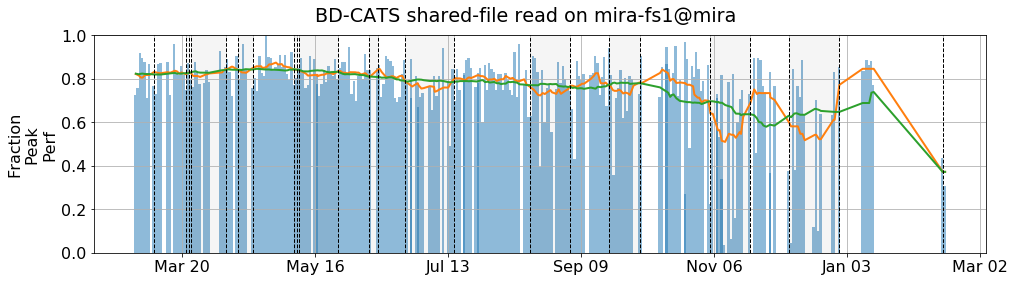

In [7]:
intercepts = abcutils.features.sma_intercepts(example_df,
                                              plot_metric,
                                              short_window=short_window,
                                              long_window=long_window)
print "Identified %d intercepts with w_short = %s and w_long = %s" % (len(intercepts), short_window, long_window)

loci = abcutils.features.generate_loci_sma(example_df,
                                           plot_metric,
                                           mins=True,
                                           maxes=False,
                                           short_window=short_window,
                                           long_window=long_window)
print "Identified %d loci in %d intercepts" % (len(loci), len(intercepts))

ax = abcutils.plot.sma_overlaps(example_df,
                                plot_metric,
                                short_window=short_window,
                                long_window=long_window,
                                sma_intercepts=intercepts)

#ax = abcutils.plot.locus_summary(example_df,
#                                 plot_metric,
#                                 loci,
#                                 align="edge")

ax.get_figure().suptitle("%s on %s" % (abcutils.CONFIG['benchmark_labels'].get(BENCHMARK_ID, BENCHMARK_ID), TEST_PLATFORM))

# Add boundaries
ymin, ymax = ax.set_ylim(0, 1)
for x in intercepts['_datetime_start']:
    ax.plot([abcutils.core.pd2epoch(x), abcutils.core.pd2epoch(x)], [ymin, ymax], color='black', linestyle='--', linewidth=1)

In [8]:
regions = list(abcutils.features.intercepts_to_region(example_df, intercepts))
print "Identified %d regions from %d intercepts" % (len(regions), len(intercepts))

print "Region schema has %d columns" % len(regions[0].columns)

Identified 23 regions from 24 intercepts
Region schema has 221 columns


## Classification

### Generate or load calculated contributors

This can take an inconvenient amount of time, so we cache the results to `contributors.hdf`

In [398]:
all_contributors = None

try:
    all_contributors = pandas.read_hdf('contributors.hdf5', 'contributors')
except IOError:
    pass

if all_contributors is None:
    grouped_df = filtered_df.groupby(by=group_by)
    for group in grouped_df.groups:
        example_df = grouped_df.get_group(group)

        intercepts = abcutils.features.sma_intercepts(example_df,
                                                      plot_metric,
                                                      short_window=short_window,
                                                      long_window=long_window)

        loci = abcutils.features.generate_loci_sma(example_df,
                                                   plot_metric,
                                                   mins=True,
                                                   maxes=False,
                                                   short_window=short_window,
                                                   long_window=long_window)
        regions = list(abcutils.features.intercepts_to_region(example_df, intercepts))

        for region in regions:
            contributors = abcutils.classify.identify_contributors(region=region,
                                                    target_column=plot_metric,
                                                    target_index=region[plot_metric].idxmin(),
                                                    correlate_columns=abcutils.CONFIG['umami_row_order'],
                                                    want_good=False,
                                                    classifier='minmax')
            if all_contributors is None:
                all_contributors = contributors
            else:
                all_contributors = pandas.concat((all_contributors, contributors))

    all_contributors.index = numpy.arange(len(all_contributors))
    all_contributors.to_hdf('contributors.hdf5', key='contributors', mode='w', format='fixed', complevel=9, complib='zlib')

In [399]:
print "Number of target indices:", len(all_contributors['target_index'].unique())

Number of target indices: 1146


Apply filters to remove very high p-value measurements from the dataset.  These cause problems when performing significance testing later on, since they dilute the significance of the results.

In [411]:
# Drop any contributors who lack statistical confidence by virtue of their domain
#significant_contributors = all_contributors[all_contributors['random_pvalue'] < 0.10]

# Also drop any contributors who lack statistical confidence because of duplicate values
significant_contributors = all_contributors[all_contributors['pvalue'] < 0.10]

# Keep all data and let p-values speak for themselves
#significant_contributors = all_contributors

print "Discarding %d contributors with p-values < 0.10" % (len(all_contributors) - len(significant_contributors))

print "Number of contributors remaining:", len(significant_contributors)
print "Number of target indices ('bad' jobs):", len(significant_contributors['target_index'].unique())
print "Number of unclassified jobs:", (all_contributors.groupby(['target_index']).sum()['target_metric_matches'] < 1.0).sum()

Discarding 5246 contributors with p-values < 0.10
Number of contributors remaining: 2947
Number of target indices ('bad' jobs): 490
Number of unclassified jobs: 80


Average fraction of matches per metric


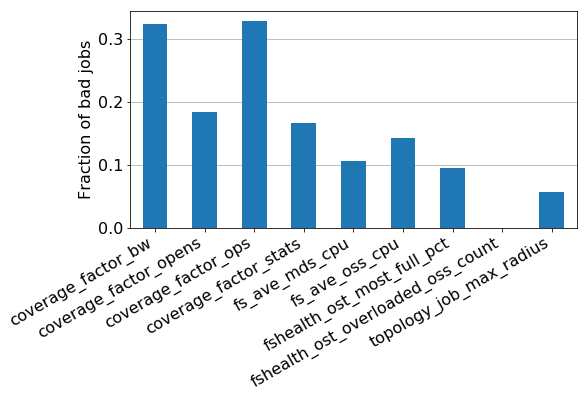

In [417]:
fig, ax = matplotlib.pyplot.subplots(figsize=(8,4))

print "Average fraction of matches per metric"
significant_contributors[['_test_platform', 'target_metric_matches', 'metric_name']]\
    .groupby(['metric_name'])\
    .mean()\
    .plot(kind='bar', ax=ax)
ax.get_legend().set_visible(False)
ax.set_ylabel("Fraction of bad jobs")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.yaxis.grid(True)
ax.set_axisbelow(True)
pass

In [419]:
tagged_metric_counts = pandas.pivot_table(significant_contributors,
                                          values='target_metric_matches',
                                          index=['metric_name'],
                                          columns=['_test_platform'],
                                          aggfunc=numpy.sum).fillna(0.0)
tagged_metric_counts

_test_platform,cscratch@cori-knl,mira-fs1@mira,scratch1@edison,scratch2@edison,scratch3@edison
metric_name,,,,,
coverage_factor_bw,22.0,20.0,29.0,41.0,36.0
coverage_factor_opens,14.0,17.0,21.0,22.0,13.0
coverage_factor_ops,0.0,24.0,0.0,0.0,0.0
coverage_factor_stats,3.0,0.0,10.0,15.0,13.0
fs_ave_mds_cpu,9.0,0.0,12.0,10.0,12.0
fs_ave_oss_cpu,13.0,0.0,8.0,15.0,22.0
fshealth_ost_most_full_pct,2.0,3.0,4.0,22.0,15.0
fshealth_ost_overloaded_oss_count,0.0,0.0,0.0,0.0,0.0
topology_job_max_radius,13.0,0.0,3.0,6.0,1.0


In [420]:
metric_observation_counts = pandas.pivot_table(significant_contributors,
                                               values='target_metric_matches',
                                               index=['metric_name'],
                                               columns=['_test_platform'],
                                               aggfunc=lambda x: (~numpy.isnan(x)).sum()).fillna(0.0)
metric_observation_counts

_test_platform,cscratch@cori-knl,mira-fs1@mira,scratch1@edison,scratch2@edison,scratch3@edison
metric_name,,,,,
coverage_factor_bw,96.0,61.0,91.0,108.0,101.0
coverage_factor_opens,98.0,73.0,91.0,108.0,103.0
coverage_factor_ops,0.0,73.0,0.0,0.0,0.0
coverage_factor_stats,59.0,0.0,55.0,66.0,65.0
fs_ave_mds_cpu,102.0,0.0,91.0,108.0,103.0
fs_ave_oss_cpu,102.0,0.0,91.0,108.0,103.0
fshealth_ost_most_full_pct,102.0,78.0,91.0,108.0,103.0
fshealth_ost_overloaded_oss_count,5.0,0.0,0.0,0.0,0.0
topology_job_max_radius,102.0,0.0,91.0,108.0,103.0


In [421]:
# divide the number of contributors by the number of times that contributor was
# ever observed to get its contribution to the overall fraction of regions where
# that metric was implicated
contributor_distribution = tagged_metric_counts.div(metric_observation_counts.sum(axis=1), axis=0)
contributor_distribution = contributor_distribution.reindex(index=contributor_distribution.sum(axis=1).sort_values(ascending=False).index)
try:
    del contributor_distribution.columns.name
except AttributeError:
    pass
contributor_distribution

,cscratch@cori-knl,mira-fs1@mira,scratch1@edison,scratch2@edison,scratch3@edison
metric_name,,,,,
coverage_factor_ops,0.000000,0.328767,0.000000,0.000000,0.000000
coverage_factor_bw,0.048140,0.043764,0.063457,0.089716,0.078775
coverage_factor_opens,0.029598,0.035941,0.044397,0.046512,0.027484
coverage_factor_stats,0.012245,0.000000,0.040816,0.061224,0.053061
fs_ave_oss_cpu,0.032178,0.000000,0.019802,0.037129,0.054455
fs_ave_mds_cpu,0.022277,0.000000,0.029703,0.024752,0.029703
fshealth_ost_most_full_pct,0.004149,0.006224,0.008299,0.045643,0.031120
topology_job_max_radius,0.032178,0.000000,0.007426,0.014851,0.002475
fshealth_ost_overloaded_oss_count,0.000000,0.000000,0.000000,0.000000,0.000000


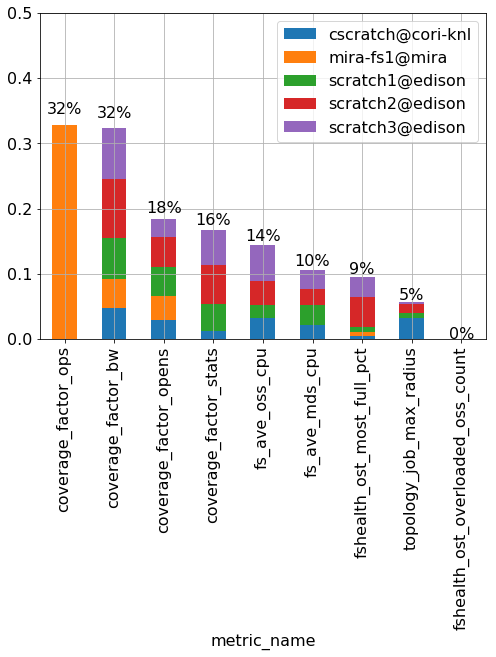

In [422]:
fig, ax = matplotlib.pyplot.subplots(figsize=(8,6))

contributor_distribution.plot.bar(stacked=True, ax=ax)
ax.grid()
ax.set_ylim(0, 0.5)
ax.set_

for index, x_value in enumerate(ax.get_xticks()):
    ax.annotate("%d%%" % (100.0 * row_sums[index]), xy=(x_value, row_sums[index] * 1.05), ha='center')

## Assert confidence

We use the binomial distribution (Bernoulli trials) to approximate the p-value of each assertion above.

In [396]:
for metric in contributor_distribution.index.values: # ['fs_ave_oss_cpu']: #
    prob_success = 1.0
    successes = []
    prob_failure = 1.0
    failures = []
    num_matches = 0
    metric_measures = significant_contributors[significant_contributors['metric_name'] == metric]
    
    for row in metric_measures.itertuples():
        if row.target_metric_matches:
            num_matches += 1
            prob_success *= row.pvalue
            successes.append(row.pvalue)
        else:
            prob_failure *= (1.0 - row.pvalue)
            failures.append(row.pvalue)

    pick_n = num_matches
    out_of = len(metric_measures)
    
#   pick_n = round(numpy.float64(pick_n) / out_of * 100)
#   out_of = 100 - pick_n
    print metric, pick_n, out_of, scipy.stats.binom_test(pick_n,
                                                         out_of,
                                                         scipy.stats.mean(successes),
                                                         alternative='greater')
    
#   binom = scipy.special.binom(out_of, pick_n)
#   print metric, pick_n, out_of, binom * prob_success * prob_failure

coverage_factor_ops 24 73 3.8665586555e-12
coverage_factor_bw 148 457 2.9860572157e-64
coverage_factor_opens 87 473 3.58578774558e-18
coverage_factor_stats 41 245 9.62105841918e-08
fs_ave_oss_cpu 58 404 1.39775511403e-09
fs_ave_mds_cpu 43 404 0.00762960574409
fshealth_ost_most_full_pct 46 482 0.0036053885563
topology_job_max_radius 23 404 0.843039540829
fshealth_ost_overloaded_oss_count 0 5 nan
